# Champion Challenger comparison between 2 decision automations

## Get the power of big simulations to build trust in your decision automation with IBM Cloud Pak for Business Automation

This notebook shows a champion challenger comparison between 2 versions of a decision automation performed by IBM Cloud Pak for Business Automation. More precisely we use Automation Decision Services to model a low code decision service. Then we created 2 versions:

<ul>
<li>v1 is the original Loan Approval with Task sample. This is the champion.</li>
<li>v2 is a variation of v2 with a max loan amount set to 1.3 M, changed scores, and an added rule for railway SSN.</li>
</ul>

This report shows the decisions performed with v1 and v2 decision logic when applied to the same set of requests. Each decision has been captured all input parameters, the answer with all output parameters computed by the decision logic, and the trace. In the trace you find the list of the executed rules and ML models.

How perform comparatively these 2 versions? Does v2 behaves better than v1 at the light of the business KPIs?

In [1]:
# Parameters
BASE_DIR = "/home/jovyan/work" #"/Users/tiemokodembele/Documents/internShip/simulatte"
first_run = {"uid": 12, "simulationUid": 9, "name": "my runner", "description": "string", "createDate": 1656688183187, "trace": True, "dataSink": {"format": "JSON", "folderPath": f"{BASE_DIR}/data/ADS/loanvalidation", "uri": f"{BASE_DIR}/data/ADS/loanvalidation/run_my runner_20220701_170943.json", "username": "string", "password": "string", "uid": 30}, "decisionService": {"type": "ADS", "endPoint": "https://cpd-cp4a.apps.ads2201.cp.fyre.ibm.com/ads/runtime/api/v1/deploymentSpaces/embedded/decisions/_082392706%2Fbanking%2Fapproval_with_tasks%2FloanApprovalWithTasksDecisionService%2F1.1.0%2FloanApprovalWithTasksDecisionService-1.1.0.jar/operations/approvalWithTasks/execute", "authType": "ZEN_TOKEN", "username": "string", "password": "string", "key": "string", "value": "string", "token": "MDgyMjEzNzA2OjB6M3lwc29MZTJOOE1sQ2pDVDVSVXlmSHNXRDhDbjBKc1ZKZlN1aEI=", "headerPrefix": "string", "uid": 21}, "executor": {"type": "JSE", "mode": "REMOTE", "capability": "ODM", "uid": 12}, "runReport": {"uid": 12, "status": "FINISHED", "numberOfDecisions": 5000, "numberOfRequests": 5000, "progress": 1.0, "duration": 938931, "numberOfDecisionsPerSecond": 5.325205}, "notebookUri": f"{BASE_DIR}/notebook/ads-vs-odm-loanvalidation-analytics.ipynb"}
second_run = {"uid": 13, "simulationUid": 9, "name": "my runner", "description": "string", "createDate": 1656688188342, "trace": True, "dataSink": {"format": "JSON", "folderPath": f"{BASE_DIR}/data/ADS/loanvalidation", "uri": f"{BASE_DIR}/data/ADS/loanvalidation/run_my runner_20220701_170948.json", "username": "string", "password": "string", "uid": 31}, "decisionService": {"type": "ADS", "endPoint": "https://cpd-cp4a.apps.ads2201.cp.fyre.ibm.com/ads/runtime/api/v1/deploymentSpaces/embedded/decisions/_082213706%2Fpf2%2Fapproval_with_tasks%2FapprovalWithTasks-2DecisionService%2F1.4.0%2FapprovalWithTasks-2DecisionService-1.4.0.jar/operations/approvalWithTasks/extendedExecute", "authType": "ZEN_TOKEN", "username": "string", "password": "string", "key": "string", "value": "string", "token": "MDgyMjEzNzA2OjB6M3lwc29MZTJOOE1sQ2pDVDVSVXlmSHNXRDhDbjBKc1ZKZlN1aEI=", "headerPrefix": "string", "uid": 22}, "executor": {"type": "JSE", "mode": "REMOTE", "capability": "ODM", "uid": 13}, "runReport": {"uid": 13, "status": "FINISHED", "numberOfDecisions": 5000, "numberOfRequests": 5000, "progress": 1.0, "duration": 942367, "numberOfDecisionsPerSecond": 5.3057885}, "notebookUri": f"{BASE_DIR}/notebook/ads-vs-odm-loanvalidation-analytics.ipynb"}


### DEPENDENCIES INSTALLATION

In [2]:
%%capture 

!pip install pgeocode
!pip install deepdiff

### LIBRAIRIES IMPORT

In [3]:
import os
import sys

import requests
import random 

import pandas as pd 
import numpy as np
import json

from IPython.display import display, HTML
from deepdiff import DeepDiff

import plotly
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected = True)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pgeocode
import re

## 1 - Comparison between two simulations 

We show the two simulation descriptions side by side. The goal is to identify the tested decisions services with their types and versions, and the data source to read the requests.

In [4]:
runs_diff = json.dumps(DeepDiff(first_run, 
                                second_run, 
                                exclude_paths={"root['uid']", 
                                                "root['name']", 
                                                "root['description']", 
                                                "root['createDate']", 
                                                "root['dataSink']", 
                                                "root['decisionService']['authType']", 
                                                "root['decisionService']['token']", 
                                                "root['decisionService']['uid']", 
                                                "root['executor']", 
                                                "root['runReport']['uid']"
                                                "root['runReport']['numberOfDecisionsPerSecond']"
                                                })['values_changed'], indent=4)



attribute_names = []
v1_values =[]
v2_values =[]
for key,value in json.loads(runs_diff).items():
     v1_values.append(value["old_value"])
     v2_values.append(value["new_value"])
     attribute_names.append('.'.join(re.findall(r'\'(.*?)\'', key)))

df = pd.DataFrame({
        'Attributes': attribute_names,
        'V1': v1_values,
        'V2': v2_values
    })
df

Attributes  \
0              decisionService.endPoint   
1                         runReport.uid   
2                    runReport.duration   
3  runReport.numberOfDecisionsPerSecond   

                                                  V1  \
0  https://cpd-cp4a.apps.ads2201.cp.fyre.ibm.com/...   
1                                                 12   
2                                             938931   
3                                           5.325205   

                                                  V2  
0  https://cpd-cp4a.apps.ads2201.cp.fyre.ibm.com/...  
1                                                 13  
2                                             942367  
3                                           5.305789

## 2 - Read the decision dataset

This report post processes the result of a simulation that wrote a dataset of automated decisions in a data lake or a local file system. The first decisions found in the v2 simulation dataset look like below for simplicity sake:

In [5]:
# data sink uris
datasink_v1_path = first_run["dataSink"]["uri"]
datasink_v2_path = second_run["dataSink"]["uri"]

outputDataV1 = []
outputDataV2 = []

if os.path.exists(datasink_v1_path):
    with open(datasink_v1_path) as file:
        filesize = os.path.getsize(datasink_v1_path)
        if filesize == 0:
            print("The file {} is empty".format(datasink_v1_path))
        else:
            while (line := file.readline().rstrip()):
                jsonLine = dict()
                line_to_json = json.loads(line)
                jsonLine["request"] = json.loads(line_to_json["request"])
                if(line_to_json["trace"]=="empty"):
                    jsonLine["trace"] = "empty"
                else:
                    jsonLine["trace"] = json.loads(line_to_json["trace"])
                jsonLine["response"] = json.loads(line_to_json["response"])

                outputDataV1.append(jsonLine)

if os.path.exists(datasink_v2_path):
    with open(datasink_v2_path) as file:
        filesize = os.path.getsize(datasink_v2_path)
        if filesize == 0:
            print("The file {} is empty".format(datasink_v2_path))
        else:
            while (line := file.readline().rstrip()):
                jsonLine = dict()
                line_to_json = json.loads(line)
                jsonLine["request"] = json.loads(line_to_json["request"])
                if(line_to_json["trace"]=="empty"): 
                    jsonLine["trace"] = "empty" 
                else: 
                    jsonLine["trace"] = json.loads(line_to_json["trace"])
                jsonLine["response"] = json.loads(line_to_json["response"])

                outputDataV2.append(jsonLine)

datasink_v1 = pd.json_normalize(outputDataV1)
datasink_v2 = pd.json_normalize(outputDataV2)

display(datasink_v1.head(5))
display(datasink_v2.head(5))

request.loan.amount  request.loan.loanToValue  \
0               783440                       0.7   
1              1787385                       0.7   
2              1733494                       0.7   
3              1350004                       0.7   
4              1210944                       0.7   

   request.loan.numberOfMonthlyPayments request.loan.startDate  \
0                                   162   2005-06-01T00:00:00Z   
1                                   183   2005-06-01T00:00:00Z   
2                                    75   2005-06-01T00:00:00Z   
3                                    72   2005-06-01T00:00:00Z   
4                                   160   2005-06-01T00:00:00Z   

  request.borrower.firstName request.borrower.lastName  \
0                     Cheryl                    Garcia   
1                   Jonathan                   Jackson   
2                      Jamie                    Howard   
3                     Andrew                   Shaffer   
4                      Marie                    Garcia   

  request.borrower.zipCode  request.borrower.creditScore  \
0                    51659                           736   
1                    43177                           527   
2                    31149                           460   
3                    18542                           751   
4                    05598                           684   

  request.borrower.birthDate  request.borrower.yearlyIncome  ...  \
0       1982-05-12T00:00:00Z                         113243  ...   
1       1968-05-12T00:00:00Z                         224186  ...   
2       1980-05-12T00:00:00Z                          39954  ...   
3       1980-05-12T00:00:00Z                         219998  ...   
4       1911-05-12T00:00:00Z                          72470  ...   

  response.borrower.yearlyIncome response.borrower.spouse  \
0                         113243                     None   
1                         224186                     None   
2                          39954                     None   
3                         219998                     None   
4                          72470                     None   

  response.borrower.SSN.serialNumber response.borrower.SSN.areaNumber  \
0                               6789                              038   
1                               6789                              424   
2                               6789                              151   
3                               6789                              258   
4                               6789                              618   

  response.borrower.SSN.groupCode               response.__DecisionID__  \
0                              45  6db66242-f6fa-4fab-a56c-e5012394ced2   
1                              45  d7a9c052-e2c9-4fb2-8183-db121b202eae   
2                              45  c55ba1cb-4f68-4024-9fa9-c13edbf76b39   
3                              45  f5b4fd8b-4ffb-4691-a755-47e584d2c1df   
4                              45  96dde91d-c6e1-4c4a-a254-a9e9aa51f6a4   

                                   response.messages response.dataValidated  \
0  [Too big Debt/Income ratio, Very low risk loan...                   True   
1                   [The loan cannot exceed 1000000]                  False   
2                   [The loan cannot exceed 1000000]                  False   
3                   [The loan cannot exceed 1000000]                  False   
4                   [The loan cannot exceed 1000000]                  False   

  response.yearlyInterestRate response.insurance  
0                       0.082                NaN  
1                       0.000                NaN  
2                       0.000                NaN  
3                       0.000                NaN  
4                       0.000                NaN  

[5 rows x 70 columns]

request.loan.amount  request.loan.loanToValue  \
0               783440                       0.7   
1              1787385                       0.7   
2              1733494                       0.7   
3              1350004                       0.7   
4              1210944                       0.7   

   request.loan.numberOfMonthlyPayments request.loan.startDate  \
0                                   162   2005-06-01T00:00:00Z   
1                                   183   2005-06-01T00:00:00Z   
2                                    75   2005-06-01T00:00:00Z   
3                                    72   2005-06-01T00:00:00Z   
4                                   160   2005-06-01T00:00:00Z   

  request.borrower.firstName request.borrower.lastName  \
0                     Cheryl                    Garcia   
1                   Jonathan                   Jackson   
2                      Jamie                    Howard   
3                     Andrew                   Shaffer   
4                      Marie                    Garcia   

  request.borrower.zipCode  request.borrower.creditScore  \
0                    51659                           736   
1                    43177                           527   
2                    31149                           460   
3                    18542                           751   
4                    05598                           684   

  request.borrower.birthDate  request.borrower.yearlyIncome  ...  \
0       1982-05-12T00:00:00Z                         113243  ...   
1       1968-05-12T00:00:00Z                         224186  ...   
2       1980-05-12T00:00:00Z                          39954  ...   
3       1980-05-12T00:00:00Z                         219998  ...   
4       1911-05-12T00:00:00Z                          72470  ...   

  response.borrower.yearlyIncome response.borrower.spouse  \
0                         113243                     None   
1                         224186                     None   
2                          39954                     None   
3                         219998                     None   
4                          72470                     None   

  response.borrower.SSN.serialNumber response.borrower.SSN.areaNumber  \
0                               6789                              038   
1                               6789                              424   
2                               6789                              151   
3                               6789                              258   
4                               6789                              618   

  response.borrower.SSN.groupCode               response.__DecisionID__  \
0                              45  4f920be9-c615-4d5f-b1fe-48acb9623533   
1                              45  bd0d3dc2-6c44-4a53-8c56-fcd689862514   
2                              45  61d494e9-9911-49bf-92a1-86a09ed25628   
3                              45  73680b52-21b1-49d9-8f9f-21bc65f6a1a3   
4                              45  4308f4a4-5f9c-4621-ab4e-d04ed2789cd7   

                                   response.messages response.dataValidated  \
0  [Too big Debt/Income ratio, Very low risk loan...                   True   
1                   [The loan cannot exceed 1300000]                  False   
2                   [The loan cannot exceed 1300000]                  False   
3                   [The loan cannot exceed 1300000]                  False   
4  [Too big Debt/Income ratio, Very low risk loan...                   True   

  response.yearlyInterestRate response.insurance  
0                       0.082                NaN  
1                       0.000                NaN  
2                       0.000                NaN  
3                       0.000                NaN  
4                       0.082                NaN  

[5 rows x 70 columns]

## 3 - Business Metrics

From each raw decision we extract or compute a set of metrics. The accepted versus rejected classification is a metric, All raw input and output metrics are eligible to be metrics. Main metrics used in this report are:

<ul>
<li>accepted/rejected status,</li>
<li>loan amount,</li>
<li>borrower's credit score,</li>
<li>borrower's yearly income</li>
</ul>

In [6]:
########### Graphs configs #############
approval_colors = ["#00CC96", "#FF6692"]
color_indices = [0, 1]

pie_chart_approval_loan_names = ['approved', 'rejected']
pie_chart_loan_amount_names = ['approved amount', 'rejected amount']
bidirectional_bar_chart_label_v2=['number of applications', 'sum of applications amounts']
bidirectional_bar_chart_label_v1=['number of applications', 'sum of applications amounts']
bidirectional_bar_chart_label=['number of rejected applications', 'sum of rejected applications amounts', 'number of approved applications', 'sum of approved applications amounts']
radar_chart_labels=['number of rejected applications', 'sum of rejected applications amounts', 'number of approved applications', 'sum of approved applications amounts', 'ratio approved/requested']

In [7]:
########### Metrics v1 #############
select_approved_decision_v2 = '`response.approved` == True'
select_rejected_decision_v2 = '`response.approved` == False'

get_decision_approval_v2 = 'response.approved'
get_decision_amount_v2 = 'response.loan.amount'
get_decision_borrower_zipcode_v2 = 'response.borrower.zipCode'
get_decision_borrower_yearly_income_v2 = 'response.borrower.yearlyIncome'
get_decision_borrower_credit_score_v2 = "response.borrower.creditScore"
get_decision_id_v2 = 'response.__DecisionID__'
get_decision_reimbursement_rate_v2 = 'response.yearlyInterestRate'
get_decision_monthly_repayment_v2 = 'response.monthlyRepayment'

########### Metrics V2 #############
select_approved_decision_v1 = '`response.approved` == True'
select_rejected_decision_v1 = '`response.approved` == False'

get_decision_approval_v1 = 'response.approved'
get_decision_amount_v1 = 'response.loan.amount'
get_decision_borrower_zipcode_v1 = 'response.borrower.zipCode'
get_decision_borrower_yearly_income_v1 = 'request.borrower.yearlyIncome'
get_decision_borrower_credit_score_v1 = "request.borrower.creditScore"
get_decision_id_v1 = 'response.__DecisionID__'
get_decision_reimbursement_rate_v1 = 'response.yearlyInterestRate'
get_decision_monthly_repayment_v1 = 'response.monthlyRepayment'


## 4 - Business KPIs

Key Performance Indicators are aggregated counters to judge the decision set. Examples of basic KPIs for loan approval are:

<ul>
<li>Sum of approved applications / total number of applications,</li>
<li>Sum of rejected applications / total number of applications,</li>
<li>Total of approved loan amounts,</li>
<li>Total of rejected loan amounts</li>
</ul>

Only limits are the imagination and computational power of Python, Scala or R languages.

In [8]:
########### V2 #############
approved_loan_v2 = datasink_v2.query(select_approved_decision_v2)
rejected_loan_v2 = datasink_v2.query(select_rejected_decision_v2)


########### V1 #############
approved_loan_v1 = datasink_v1.query(select_approved_decision_v1)
rejected_loan_v1 = datasink_v1.query(select_rejected_decision_v1)




########### Approved/Rejected #############
print("V2 : Number of approved loan request = ", approved_loan_v2.shape[0])
print("V2 : Number of rejected loan request = ", rejected_loan_v2.shape[0])
print("V2 : Rate of approval = ", approved_loan_v2.shape[0]/datasink_v2.shape[0])

print("V1 : Number of approved loan request = ", approved_loan_v1.shape[0])
print("V1 : Number of rejected loan request = ", rejected_loan_v1.shape[0])
print("V1 : Rate of approval = ", approved_loan_v1.shape[0]/datasink_v1.shape[0])


########### Approved/Rejected Amount #############
print("V2 : Total approved amount = ",datasink_v2.query(select_approved_decision_v2)[get_decision_amount_v2].sum())
print("V2 : Total rejected amount = ",datasink_v2.query(select_rejected_decision_v2)[get_decision_amount_v2].sum())
print("V2 : Total requested amount = ",datasink_v2[get_decision_amount_v2].sum())

print("V1 : Total approved amount = ",datasink_v1.query(select_approved_decision_v1)[get_decision_amount_v1].sum())
print("V1 : Total rejected amount = ",datasink_v1.query(select_rejected_decision_v1)[get_decision_amount_v1].sum())
print("V1 : Total requested amount = ",datasink_v1[get_decision_amount_v1].sum())

V2 : Number of approved loan request =  925
V2 : Number of rejected loan request =  4075
V2 : Rate of approval =  0.185
V1 : Number of approved loan request =  1048
V1 : Number of rejected loan request =  3952
V1 : Rate of approval =  0.2096
V2 : Total approved amount =  274938211
V2 : Total rejected amount =  4767814177
V2 : Total requested amount =  5042752388
V1 : Total approved amount =  333764974
V1 : Total rejected amount =  4708987414
V1 : Total requested amount =  5042752388


## 5 - Visualization

### 5.1 Approval vs Rejection

We use donut representations to get an overview of the acceptation of the loans, in terms of number of applications and loan amounts

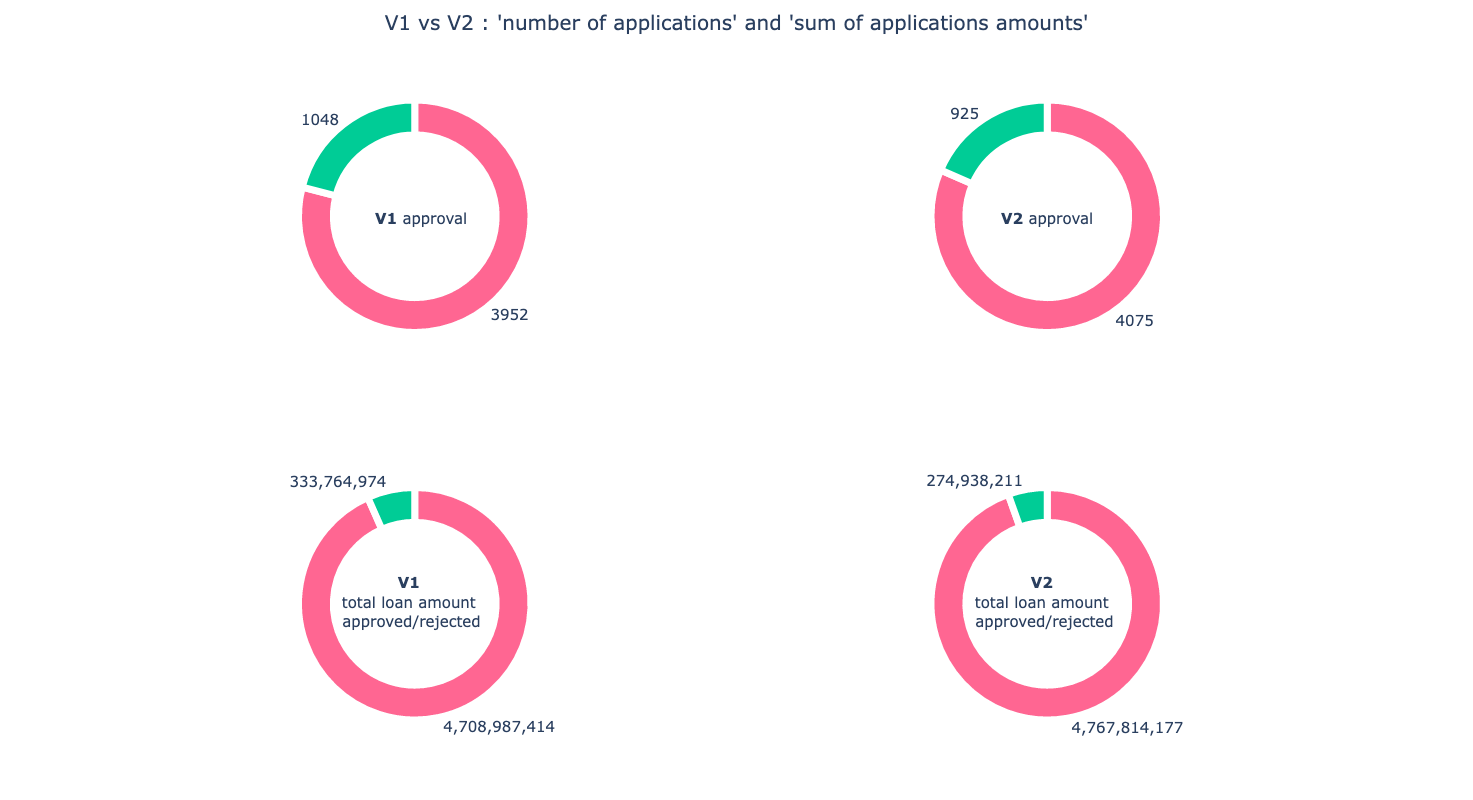

In [9]:
########### settings ###########
donut_hole = 0.7

########### Approved/Rejected PIE CHART #############
trace_approval_v2 = go.Pie(labels = pie_chart_approval_loan_names,
                            values = [approved_loan_v2.shape[0], rejected_loan_v2.shape[0]],
                            hole = donut_hole)
trace_approval_v1 = go.Pie(labels = pie_chart_approval_loan_names,
                            values = [approved_loan_v1.shape[0], rejected_loan_v1.shape[0]],
                            hole = donut_hole)


########### Approved/Rejected Amount PIE CHART #############
trace_amount_v2 = go.Pie(values= [datasink_v2.query(select_approved_decision_v2)[get_decision_amount_v2].sum(),
                                 datasink_v2.query(select_rejected_decision_v2)[get_decision_amount_v2].sum()],
                            labels=pie_chart_loan_amount_names,
                            hole = donut_hole,
                            name="Loan amount ADS")
trace_amount_v1 = go.Pie(values=[datasink_v1.query(select_approved_decision_v1)[get_decision_amount_v1].sum(),
                                datasink_v1.query(select_rejected_decision_v1)[get_decision_amount_v1].sum()],
                            labels=pie_chart_loan_amount_names,
                           hole = donut_hole,
                            name="Loan amount V1")

fig = make_subplots(rows=2, cols=2,
                    specs=[[{"type": "pie"}, {"type": "pie"}],[{"type": "pie"}, {"type": "pie"}]],
                    column_widths=[0.5, 0.5],
                    #vertical_spacing=0.001,
                    subplot_titles=("V1 approval", "ADS approval", "V1 approved/rejected amount", "ADS approved/rejected amount")
                    )

fig.add_trace(trace_approval_v1, row=1, col=1)
fig.add_trace(trace_approval_v2, row=1, col=2)
fig.add_trace(trace_amount_v1, row=2, col=1)
fig.add_trace(trace_amount_v2, row=2, col=2)

fig.update_traces(hoverinfo='label', textinfo='value', textfont_size=15, textposition="outside",
                  marker=dict(colors=approval_colors, line=dict(color='#FFFFFF', width=7)))
                
fig.update_annotations(yshift=20) # subplot tiltes

fig.update_layout(
    barmode='stack',
    plot_bgcolor = "white",
    #paper_bgcolor = 'lightgray',
    showlegend=False,
    height=800,
    title={'text': f"V1 vs V2 : 'number of applications' and 'sum of applications amounts'",
          'x':0.5,
          'y':0.98,
          'xanchor': 'center',
          'font_size': 20
    },
    annotations= [
         {
            "font": {
               "size": 15
            },
            "showarrow": False,
            "text": "<b>V1</b><br>total loan amount<br> approved/rejected",
            "x": 0.22,
            "y": 0.11
         },
         {
            "font": {
               "size": 15
            },
            "showarrow": False,
            "text": "<b>V2</b><br>total loan amount<br> approved/rejected",
            "x": 0.77,
            "y": 0.11
         },
         {
            "font": {
               "size": 15
            },
            "showarrow": False,
            "text": "<b>V1</b> approval",
            "x": 0.23,
            "y": 0.76
         },
         {
            "font": {
               "size": 15
            },
            "showarrow": False,
            "text": "<b>V2</b> approval",
            "x": 0.775,
            "y": 0.76
         }
      ],
      )

iplot(fig)

### 5.2 Represent the decisions in a yearly income, loand amount, and approval outcome space

We leverage a scatter component to represent all decisions. Each decision is colored in pink if refused or green if accepted. The circle radius depends on the amount. You can zoom in, select one decision, and get a tooltip with a summary of the decision.

We added 2 lines in the view:

<ul>
<li>one horizontal line that matches a business rule that rejectsany application with a loan amount greater than 1 M.</li>
<li>one diagonal that separates the population of never accepted application from one where accepted applications are concentrated. This observation is consistent with busines rules that enforced a maximum income/reimbursement ratio.</li>
</ul>

In [10]:
def array_normalize(values, max_value=1):
    normalized_values = []
    for value in values:
        normalized_values.append((value*max_value)/max(values))
    return normalized_values

def set_colors(values, true_color="#00CC96", false_color="#FF6692"):
    colors = []
    for value in values:
        if(value): 
            colors.append(true_color) 
        else: 
            colors.append(false_color) 
    return colors

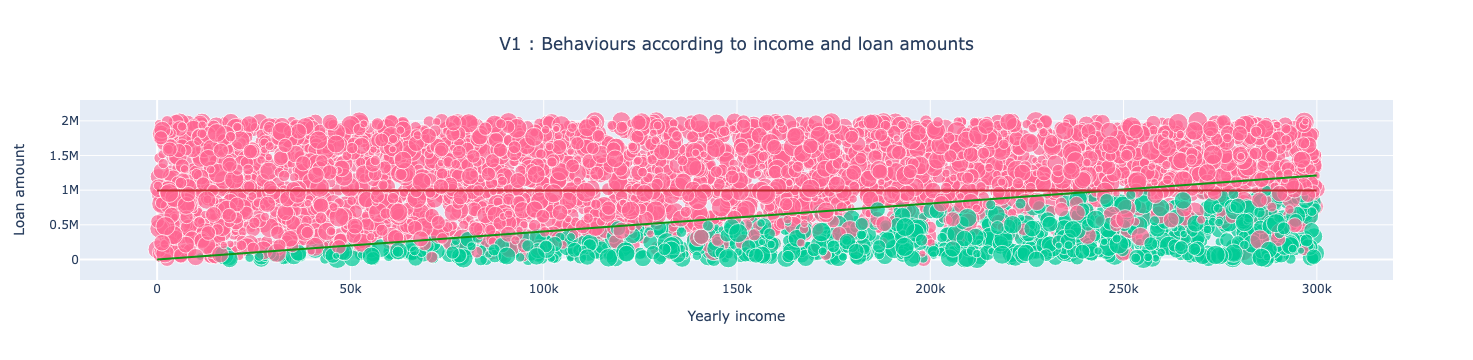

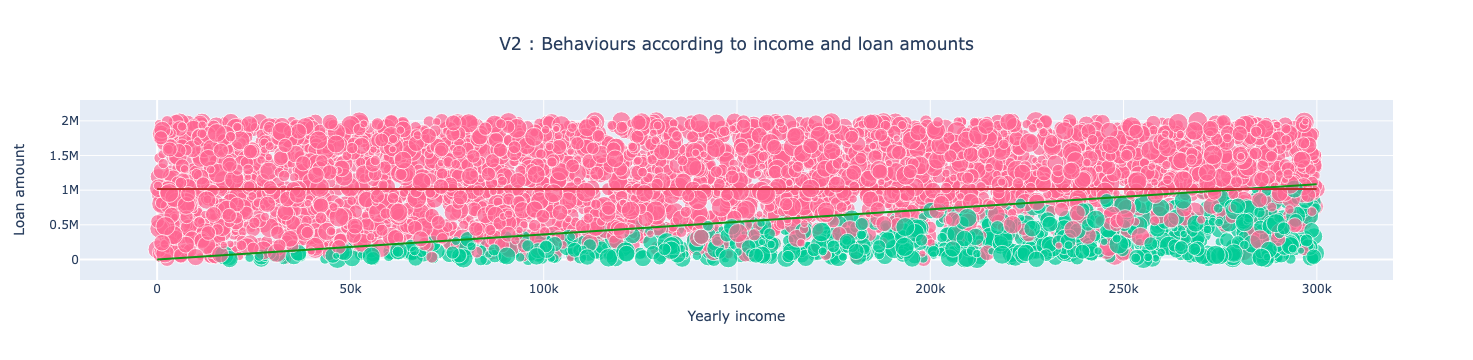

In [11]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(
                 x=datasink_v1[get_decision_borrower_yearly_income_v1],
                 y=datasink_v1[get_decision_amount_v1],
                 mode='markers',
                 marker_size=array_normalize(datasink_v1[get_decision_borrower_credit_score_v1], 20), 
                 marker_color=set_colors(datasink_v1[get_decision_approval_v1]),
                 text=datasink_v1[get_decision_approval_v1], 
                 hovertext=datasink_v1[get_decision_id_v1],
                 hovertemplate="<b>Income:</b> %{x}<br><b>Loan amount:</b> %{y}<br><b>Approval:</b> %{text}<br><b>Id:</b> %{hovertext}<extra></extra>",
                 name='V1'
))


fig1.add_trace(
    go.Scatter(
        x=np.array([0, max(datasink_v1[get_decision_borrower_yearly_income_v1])]),
        y=max(datasink_v1.query(select_approved_decision_v1)[get_decision_amount_v1]/datasink_v1.query(select_approved_decision_v1)[get_decision_borrower_yearly_income_v1])*np.array([0, max(datasink_v1[get_decision_borrower_yearly_income_v1])]),
        mode="lines",
        line=go.scatter.Line(color="#109618"),
        showlegend=False)
)
fig1.add_trace(
    go.Scatter(
        x=np.array([0, max(datasink_v1[get_decision_borrower_yearly_income_v1])]),
        y=max(datasink_v1.query(select_approved_decision_v1)[get_decision_amount_v1])*np.array([1, 1]),
        mode="lines",
        line=go.scatter.Line(color="#B82E2E"), ##B82E2E
        showlegend=False)
)


fig2 = go.Figure()
fig2.add_trace(go.Scatter(
                 x=datasink_v2[get_decision_borrower_yearly_income_v2],
                 y=datasink_v2[get_decision_amount_v2],
                 mode='markers',
                 marker_size=array_normalize(datasink_v2[get_decision_borrower_credit_score_v2], 20), 
                 marker_color=set_colors(datasink_v2[get_decision_approval_v2]),
                 text=datasink_v2[get_decision_approval_v2], 
                 hovertext=datasink_v2[get_decision_id_v2],
                 hovertemplate="<b>Income:</b> %{x}<br><b>Loan amount:</b> %{y}<br><b>Approval:</b> %{text}<br><b>Id:</b> %{hovertext}<extra></extra>",
                 name='V1'
))


fig2.add_trace(
    go.Scatter(
        x=np.array([0, max(datasink_v2[get_decision_borrower_yearly_income_v2])]),
        y=max(datasink_v2.query(select_approved_decision_v2)[get_decision_amount_v2]/datasink_v2.query(select_approved_decision_v2)[get_decision_borrower_yearly_income_v2])*np.array([0, max(datasink_v2[get_decision_borrower_yearly_income_v2])]),
        mode="lines",
        line=go.scatter.Line(color="#109618"),
        showlegend=False)
)
fig2.add_trace(
    go.Scatter(
        x=np.array([0, max(datasink_v2[get_decision_borrower_yearly_income_v2])]),
        y=max(datasink_v2.query(select_approved_decision_v2)[get_decision_amount_v2])*np.array([1, 1]),
        mode="lines",
        name='<b>Max amount</b> horizontal bar',
        line=go.scatter.Line(color="#B82E2E"), ##B82E2E
        showlegend=False)
)

fig1.update_xaxes(title_text='Yearly income')
fig1.update_yaxes(title_text='Loan amount')

fig1.update_layout(
    barmode='stack', 
    showlegend=False,
    title={'text': f"V1 : Behaviours according to income and loan amounts",
          'x':0.5,
          'xanchor': 'center'
    })


fig2.update_xaxes(title_text='Yearly income')
fig2.update_yaxes(title_text='Loan amount')

fig2.update_layout(
    barmode='stack', 
    showlegend=False,
    title={'text': f"V2 : Behaviours according to income and loan amounts",
          'x':0.5,
          'xanchor': 'center'
    })

iplot(fig1)
iplot(fig2)

### 5.3 Evaluate business ratio 

We compute the max debt on income ratio for the two versions.

In [12]:
rate1 = max(datasink_v1.query(select_approved_decision_v1)[get_decision_monthly_repayment_v1]*12/datasink_v1.query(select_approved_decision_v1)[get_decision_borrower_yearly_income_v1])
rate2 = max(datasink_v2.query(select_approved_decision_v2)[get_decision_monthly_repayment_v2]*12/datasink_v2.query(select_approved_decision_v2)[get_decision_borrower_yearly_income_v2])

print("Max debt on income ratio detected V1 : ",rate1)
print("Max debt on income ratio detected V2 : ",rate2)

Max debt on income ratio detected V1 :  0.36951143962840594
Max debt on income ratio detected V2 :  0.3295912383715464


### 5.4 Visualize approvals on yearly income and credit scores

We use a scatter view to represent the decisions this time with yearly income and credit score. We observe 2 gradients that cumulate their effects:

<ul>
<li>the higher yearly income is the more likelyhood to get the loan accepted</li>
<li>the higher is the credit score the more likelyhood to get the loan accepted</li>
</ul>

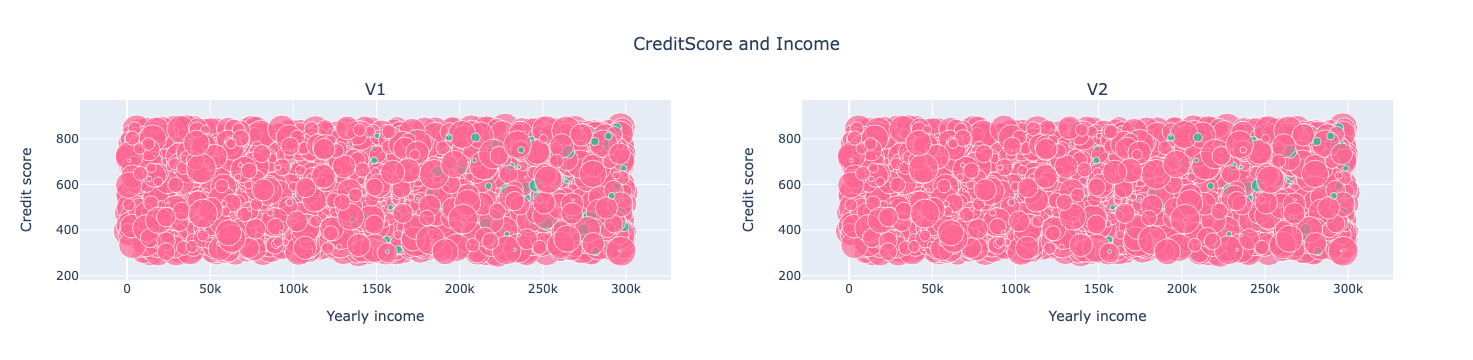

In [13]:
############ SCATTER CHART #############
max_marker_size = 30
trace_scatter_v1 = go.Scatter(
                 x=datasink_v1[get_decision_borrower_yearly_income_v1],
                 y=datasink_v1[get_decision_borrower_credit_score_v1],
                 mode='markers',
                 marker_size=array_normalize(datasink_v1[get_decision_amount_v1], max_marker_size), 
                 marker_color=set_colors(datasink_v1[get_decision_approval_v1]),
                 text=datasink_v1[get_decision_approval_v1], 
                 hovertemplate="<b>Income:</b> %{x}<br><b>creditScore:</b> %{y}<br><b>Approval:</b> %{text}<extra></extra>",
                 name='V1'
)

trace_scatter_v2 = go.Scatter(
                 x=datasink_v2[get_decision_borrower_yearly_income_v2],
                 y=datasink_v2[get_decision_borrower_credit_score_v2],
                 mode='markers',
                 marker_size=array_normalize(datasink_v2[get_decision_amount_v2], max_marker_size), 
                 marker_color=set_colors(datasink_v2[get_decision_approval_v2]),
                 text=datasink_v2[get_decision_approval_v2], 
                 hovertemplate="<b>Income:</b> %{x}<br><b>creditScore:</b> %{y}<br><b>Approval:</b> %{text}<extra></extra>",
                 name='V2',
)

fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "scatter"},{"type": "scatter"}]],
                    subplot_titles=("V1", "V2")
                    )
fig.add_trace(trace_scatter_v1, row=1, col=1)
fig.add_trace(trace_scatter_v2, row=1, col=2)

fig.update_xaxes(title_text='Yearly income')
fig.update_yaxes(title_text='Credit score')

fig.update_layout(
    barmode='stack', 
    showlegend=False,
    title={'text': f"CreditScore and Income",
          'x':0.5,
          'xanchor': 'center'
    })

iplot(fig)

### 5.5 Visualize differences in the approval

We use a scatter view to represent only the decisions that differ between the 2 versions:

<ul>
<li>green decision points mean approvals for applications that are rejected in the other version</li>
<li>pink decision points mean rejections for applications that are approved in the other version</li>
</ul>

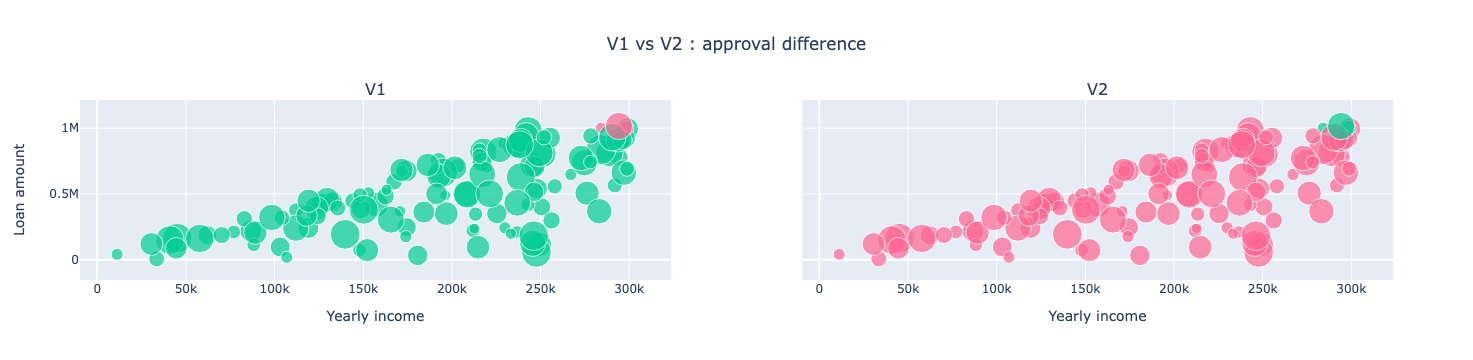

In [14]:
outputDataDiffV1 = []
outputDataDiffV2 = []
for number_of_decision in range(0, max(len(outputDataV1), len(outputDataV2))):
    if(outputDataV1[number_of_decision]['response']['approved']!=outputDataV2[number_of_decision]['response']['approved']):
        if(outputDataV1[number_of_decision]): outputDataDiffV1.append(outputDataV1[number_of_decision]) 
        if(outputDataV2[number_of_decision]): outputDataDiffV2.append(outputDataV2[number_of_decision])

datasink_diff_v1 = pd.json_normalize(outputDataDiffV1)
datasink_diff_v2 = pd.json_normalize(outputDataDiffV2)


############ SCATTER CHART #############
max_marker_size = 30
trace_scatter_v1 = go.Scatter(
                 x=datasink_diff_v1[get_decision_borrower_yearly_income_v1],
                 y=datasink_diff_v1[get_decision_amount_v1],
                 mode='markers',
                 marker_size=array_normalize(datasink_diff_v1[get_decision_borrower_credit_score_v1], max_marker_size), 
                 marker_color=set_colors(datasink_diff_v1[get_decision_approval_v1]),
                 text=datasink_diff_v1[get_decision_approval_v1], 
                 hovertemplate="<b>Income:</b> %{x}<br><b>creditScore:</b> %{y}<br><b>Approval:</b> %{text}<extra></extra>",
                 name='V1'
)

trace_scatter_v2 = go.Scatter(
                 x=datasink_diff_v2[get_decision_borrower_yearly_income_v2],
                 y=datasink_diff_v2[get_decision_amount_v2],
                 mode='markers',
                 marker_size=array_normalize(datasink_diff_v2[get_decision_borrower_credit_score_v2], max_marker_size), 
                 marker_color=set_colors(datasink_diff_v2[get_decision_approval_v2]),
                 text=datasink_diff_v2[get_decision_approval_v2], 
                 hovertemplate="<b>Income:</b> %{x}<br><b>creditScore:</b> %{y}<br><b>Approval:</b> %{text}<extra></extra>",
                 name='V2',
)

fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "scatter"},{"type": "scatter"}]],
                    shared_yaxes=True,
                    subplot_titles=("V1", "V2")
                    )
fig.add_trace(trace_scatter_v1, row=1, col=1)
fig.add_trace(trace_scatter_v2, row=1, col=2)

fig.update_xaxes(title_text='Yearly income')
fig.update_yaxes(title_text='Loan amount', row=1, col=1)

fig.update_layout(
    barmode='stack', 
    showlegend=False,
    title={'text': f"V1 vs V2 : approval difference",
          'x':0.5,
          'xanchor': 'center'
    })

iplot(fig)

### 5.6 Visualize Multiple Business KPIs

We use a bar graph to compare the 2 relative performances of the decision sets.

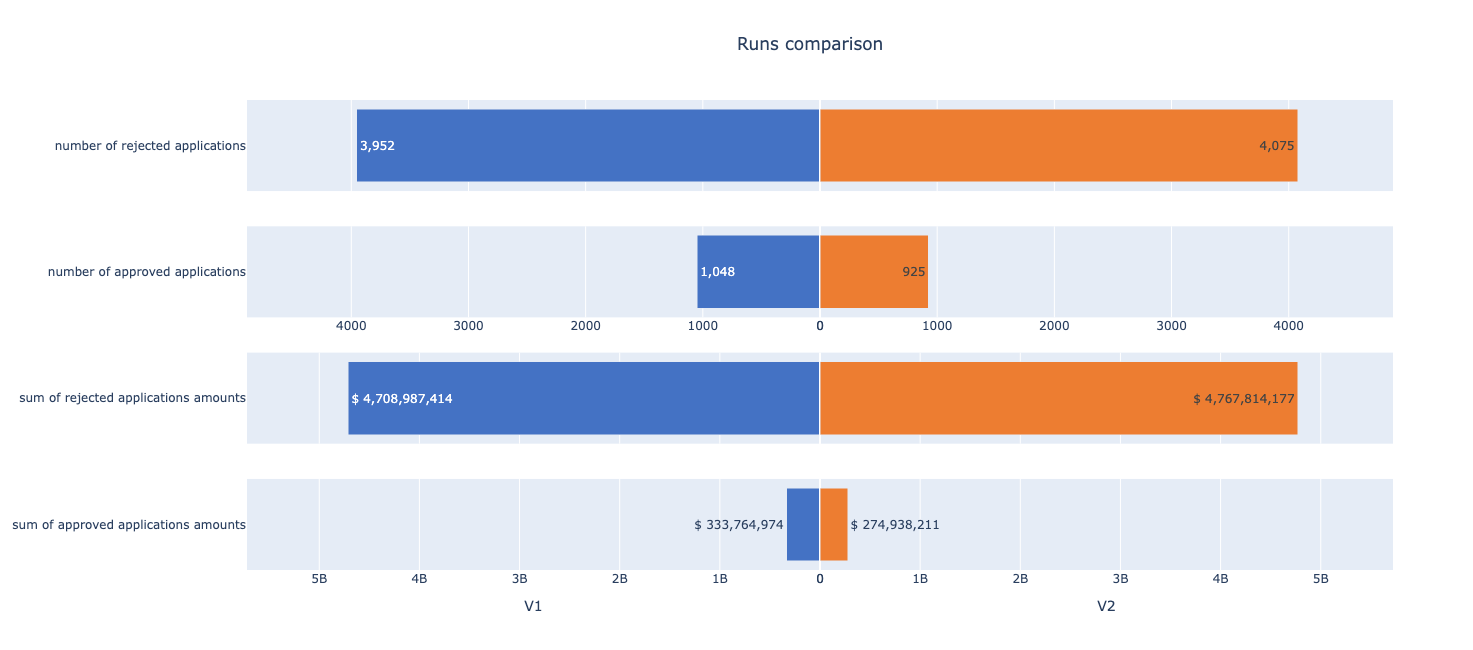

In [15]:
fig = make_subplots(rows=4, cols=2, specs=[[{}, {}], [{}, {}], [{}, {}], [{}, {}]], shared_xaxes=False,
                    shared_yaxes=True, horizontal_spacing=0)

rejected_loan=[datasink_v1.query(select_rejected_decision_v1).shape[0], datasink_v2.query(select_rejected_decision_v2).shape[0]]
rejected_loan_amount=[datasink_v1.query(select_rejected_decision_v1)[get_decision_amount_v1].sum(), datasink_v2.query(select_rejected_decision_v2)[get_decision_amount_v2].sum()]
approved_loan=[datasink_v1.query(select_approved_decision_v1).shape[0], datasink_v2.query(select_approved_decision_v2).shape[0]]
approved_loan_amount=[datasink_v1.query(select_approved_decision_v1)[get_decision_amount_v1].sum(), datasink_v2.query(select_approved_decision_v2)[get_decision_amount_v2].sum()]


fig.append_trace(go.Bar(
    y=['number of rejected applications'],
    x=[rejected_loan[0]],
    name='Rejected',
    text="{:,}".format(rejected_loan[0]),
    textposition='inside',
    showlegend=False,
    marker_color='#4472c4',
    #base=0,
    orientation='h',
), 1, 1)
fig.append_trace(go.Bar(
    y=['number of rejected applications'],
    x=[rejected_loan[1]],
    name='Rejected',
    text="{:,}".format(rejected_loan[1]),
    #base=0,
    textposition='inside',
    showlegend=False,
    orientation='h',
    marker_color='#ed7d31'
), 1, 2)

fig.append_trace(go.Bar(
    y=['number of approved applications'],
    x=[approved_loan[0]],
    name='Approved',
    text="{:,}".format(approved_loan[0]),
    textposition='inside',
    showlegend=False,
    marker_color='#4472c4',
    #base=0,
    orientation='h',
), 2, 1)
fig.append_trace(go.Bar(
    y=['number of approved applications'],
    x=[approved_loan[1]],
    name='Approved',
    text="{:,}".format(approved_loan[1]),
    #base=0,
    textposition='inside',
    showlegend=False,
    orientation='h',
    marker_color='#ed7d31'
), 2, 2)

fig.append_trace(go.Bar(
    y=['sum of rejected applications amounts'],
    x=[rejected_loan_amount[0]],
    name='Rejected',
    text="$ {:,}".format(rejected_loan_amount[0]),
    textposition='inside',
    showlegend=False,
    marker_color='#4472c4',
    #base=0,
    orientation='h',
), 3, 1)
fig.append_trace(go.Bar(
    y=['sum of rejected applications amounts'],
    x=[rejected_loan_amount[1]],
    name='Rejected',
    text="$ {:,}".format(rejected_loan_amount[1]),
    #base=0,
    textposition='inside',
    showlegend=False,
    orientation='h',
    marker_color='#ed7d31'
), 3, 2)

fig.append_trace(go.Bar(
    y=['sum of approved applications amounts'],
    x=[approved_loan_amount[0]],
    name='Approved',
    text="$ {:,}".format(approved_loan_amount[0]),
    textposition='outside',
    showlegend=False,
    marker_color='#4472c4',
    #base=0,
    orientation='h',
), 4, 1)
fig.append_trace(go.Bar(
    y=['sum of approved applications amounts'],
    x=[approved_loan_amount[1]],
    name='Approved',
    text="$ {:,}".format(approved_loan_amount[1]),
    #base=0,
    textposition='outside',
    showlegend=False,
    orientation='h',
    marker_color='#ed7d31'
), 4, 2)

butterfly_amount_view_width_ratio = max([datasink_v2.query(select_rejected_decision_v2)[get_decision_amount_v2].sum(),
                                        datasink_v2.query(select_approved_decision_v2)[get_decision_amount_v2].sum(),
                                        datasink_v1.query(select_rejected_decision_v1)[get_decision_amount_v2].sum(),
                                        datasink_v1.query(select_approved_decision_v1)[get_decision_amount_v2].sum()]) * 1.2

butterfly_approval_view_width_ratio = max([datasink_v2.query(select_rejected_decision_v2).shape[0],
                                        datasink_v2.query(select_approved_decision_v2).shape[0],
                                        datasink_v1.query(select_rejected_decision_v1).shape[0],
                                        datasink_v1.query(select_approved_decision_v1).shape[0]]) * 1.2

fig.update_xaxes(showticklabels=False, row=1, col=1, range=[butterfly_approval_view_width_ratio, 0])
fig.update_xaxes(showticklabels=False, row=1, col=2, range=[0, butterfly_approval_view_width_ratio])

fig.update_xaxes(showticklabels=True, row=2, col=1, range=[butterfly_approval_view_width_ratio, 0])
fig.update_xaxes(showticklabels=True, row=2, col=2, range=[0, butterfly_approval_view_width_ratio])

fig.update_xaxes(showticklabels=False, row=3, col=1, range=[butterfly_amount_view_width_ratio, 0])
fig.update_xaxes(showticklabels=False, row=3, col=2, range=[0, butterfly_amount_view_width_ratio])

fig.update_xaxes(showticklabels=True, title_text="V1", row=4, col=1, range=[butterfly_amount_view_width_ratio, 0])
fig.update_xaxes(showticklabels=True, title_text="V2", row=4, col=2, range=[0, butterfly_amount_view_width_ratio])


fig.update_layout(
    barmode='stack',
    height=650,
    title={'text': f"Runs comparison",
          'x':0.55,
          'xanchor': 'center'
    })

"""
fig.update_yaxes(
        ticktext=bidirectional_bar_chart_label,
        tickvals=bidirectional_bar_chart_label
    )
"""

iplot(fig)

### 5.7 Visualize Multiple Business KPIs

We use a radar (named too as Kiviat diagram or spyder) to represent the relative performances of the decision set.

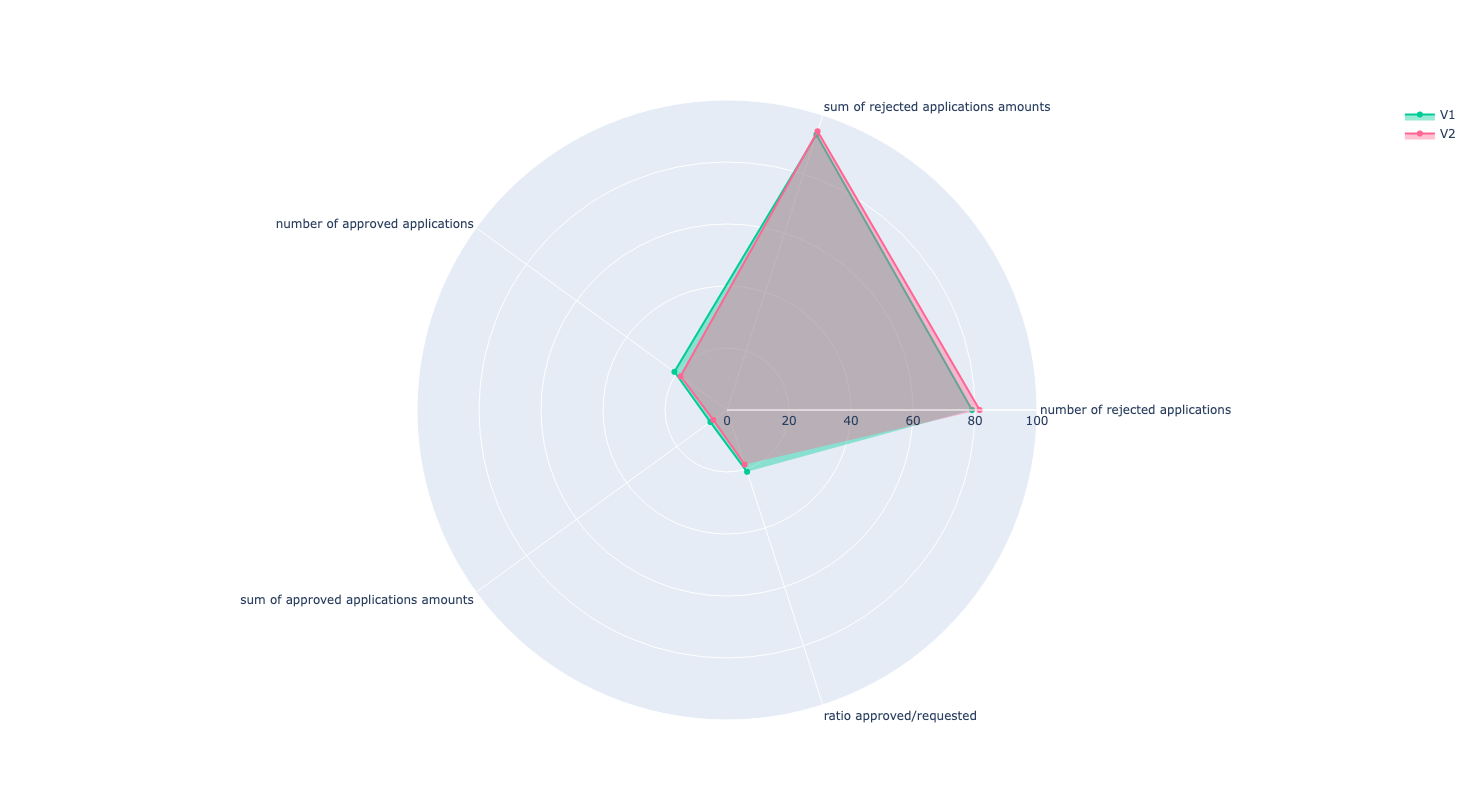

In [16]:
fig = go.Figure()

#radar dimension normalization 
radar_max_value = 100

values = np.array([[rejected_loan[0], rejected_loan_amount[0], approved_loan[0], approved_loan_amount[0], approved_loan[0]/(approved_loan[0]+rejected_loan[0])],
                   [rejected_loan[1], rejected_loan_amount[1], approved_loan[1], approved_loan_amount[1], approved_loan[1]/(approved_loan[1]+rejected_loan[1])],
                   [
                    max(datasink_v2.shape[0], datasink_v1.shape[0]), 
                    max(datasink_v2[get_decision_amount_v2].sum(), datasink_v1[get_decision_amount_v1].sum()), 
                    max(datasink_v2.shape[0], datasink_v1.shape[0]),
                    max(datasink_v2[get_decision_amount_v2].sum(), datasink_v1[get_decision_amount_v1].sum()), 
                    1
                   ]
                  ])
normed_values = (values*radar_max_value) / values.max(axis=0)

def radar_normalization(values, max_value):
    normalized_values = []
    for value in values:
        normalized_values.append((value*max_value)/max(values))
    return normalized_values

fig.add_trace(go.Scatterpolar(
      r=normed_values[0],
      theta=radar_chart_labels,
      marker_color='rgb(0,204,150)',
      fillcolor='rgba(0,204,150,0.4)',
      fill='toself',
      name='V1',
))
fig.add_trace(go.Scatterpolar(
      r=normed_values[1],
      theta=radar_chart_labels,
      marker_color='rgb(255, 102, 146)',
      fillcolor='rgba(255, 102, 146,0.4)',
      fill='toself',
      name='V2'
))

fig.update_layout(
  height=800,
  polar=dict(
    #bgcolor= 'rgb(239, 239, 232)',
    radialaxis=dict(
      visible=True,
      range=[0, radar_max_value],
      #linecolor='red',
      #gridcolor='red',
      #axiscolor='red',
      #tickcolor='red',
    )),
  #showlegend=False
)

fig.show()

### 5.8 Show the approval distributions

We use violon representations to show the distributions of the approved versus rejected applications projected on the loan amount dimension. As a confirmation accepted applications are under the 1M limit and are concentrated on low amounts

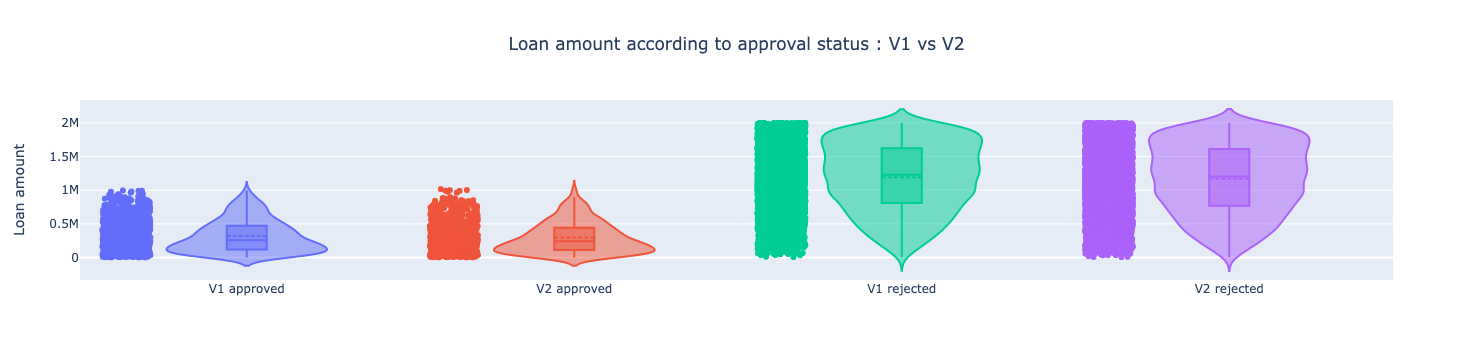

In [17]:
subplot_titles = ['V1 approved', 'V2 approved', 'V1 rejected', 'V2 rejected']
select_decision_approval_status = [select_approved_decision_v1, select_approved_decision_v2, select_rejected_decision_v1, select_rejected_decision_v2]
datasink =[datasink_v1, datasink_v2, datasink_v1, datasink_v2]
get_decision_value = [get_decision_amount_v1, get_decision_amount_v2, get_decision_amount_v1, get_decision_amount_v2] # Y value 

fig = go.Figure()
for idx, approval in enumerate(select_decision_approval_status):
    fig.add_trace(go.Violin(y=datasink[idx].query(approval)[get_decision_value[idx]],
                            name=subplot_titles[idx],
                            box_visible=True,
                            meanline_visible=True,
                            points='all'
                            ))

fig.update_yaxes(title_text='Loan amount')

fig.update_layout(
    barmode='stack', 
    showlegend=False,
    title={'text': f"Loan amount according to approval status : V1 vs V2",
          'x':0.5,
          'xanchor': 'center'
    })

fig.show()

### 5.9 - Take benefit of geographical tagging

We leverage the zipcode input parameter to locate the borrowers. It can help to detect if any correlation between the location (country, state) and the approval decision.

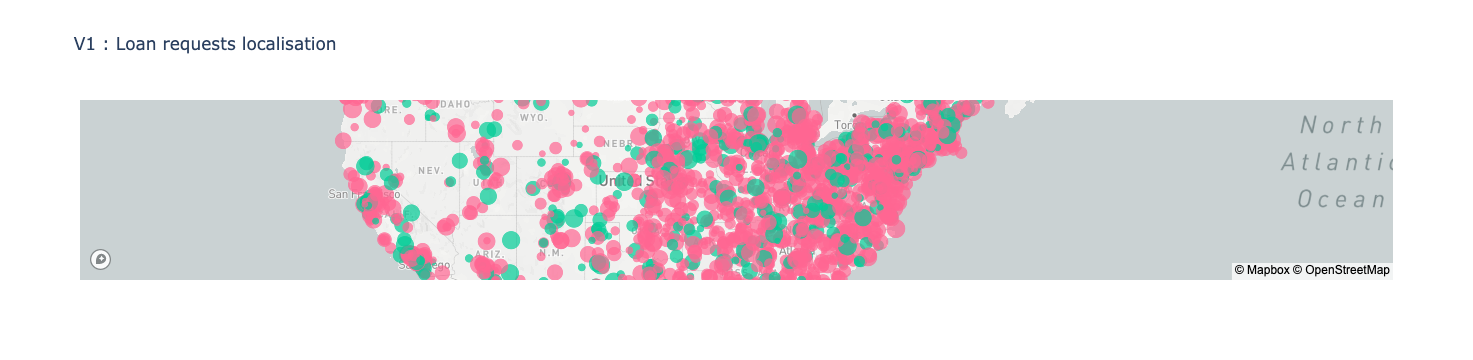

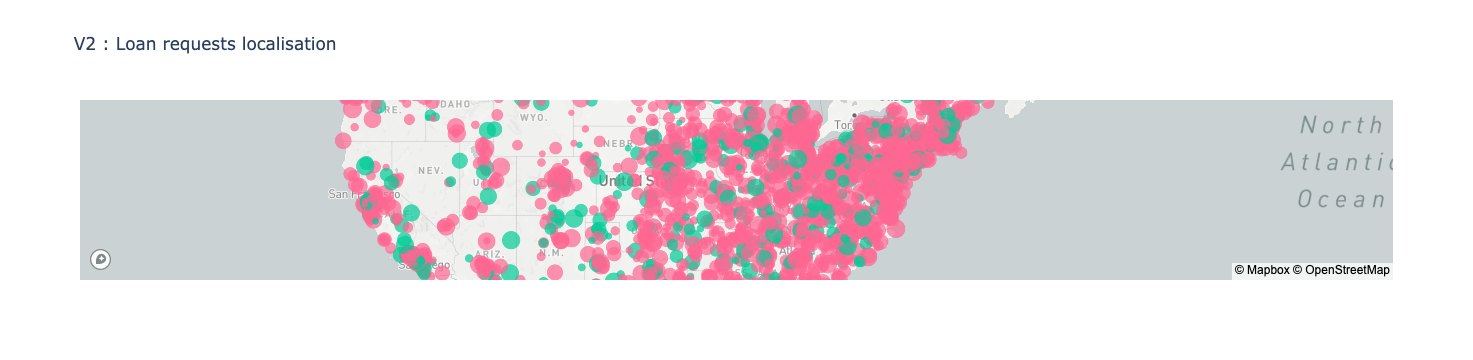

In [18]:
mapbox_access_token = "pk.eyJ1IjoiZGVtYmVsZXQiLCJhIjoiY2t0Mm5oeWo4MGx6ODJ3cXAwejNtMTFncCJ9.9cyxovpJjJUINMrw4ofe_g"

nomi = pgeocode.Nominatim('us')

df1=nomi.query_postal_code(datasink_v1[get_decision_borrower_zipcode_v1].values)

fig1 = go.Figure(data=go.Scattermapbox(
        lon = df1['longitude'],
        lat = df1['latitude'],
        text = df1['place_name'],
        mode = 'markers',
        marker=go.scattermapbox.Marker(
            size=array_normalize(datasink_v1[get_decision_borrower_credit_score_v1], 20),
            color=set_colors(datasink_v1[get_decision_approval_v1])
        ),
        ))

fig1.update_layout(
    title='V1 : Loan requests localisation',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=df1['latitude'].mean(),
            lon=df1['longitude'].mean()
        ),
        pitch=0,
        zoom=3,
        style='light'
    ),
)
fig1.show()


df2=nomi.query_postal_code(datasink_v2[get_decision_borrower_zipcode_v2].values)

fig2 = go.Figure(data=go.Scattermapbox(
        lon = df2['longitude'],
        lat = df2['latitude'],
        text = df2['place_name'],
        mode = 'markers',
        marker=go.scattermapbox.Marker(
            size=array_normalize(datasink_v2[get_decision_borrower_credit_score_v2], 20),
            color=set_colors(datasink_v2[get_decision_approval_v2])
        ),
        ))

fig2.update_layout(
    title='V2 : Loan requests localisation',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=df2['latitude'].mean(),
            lon=df2['longitude'].mean()
        ),
        pitch=0,
        zoom=3,
        style='light'
    ),
)
fig2.show()

## 6 - Go inside the decisions

We exploit the trace in each of the decision to extract how their outcome was computed. We get the executed and we aggregate them to understand their coverage for this decision set.

In [19]:
def get_rules(record):
    rules = []
    if record["recordType"]=="Rule":
        rules.append(record)
    else:
        if "nestedRecords" in record["properties"]:
            for new_record in record["properties"]["nestedRecords"]:
                rules.extend(get_rules(new_record))
    
    return rules

In [20]:
rules_v1 = []
rules_v2 = []

for number_of_decision in range(0,len(outputDataV1)):
    nested_records = outputDataV1[number_of_decision]['trace']['rootRecord']['properties']['nestedRecords']
    for record in nested_records:
        rules_v1.extend(get_rules(record))

for number_of_decision in range(0,len(outputDataV2)):
    nested_records = outputDataV2[number_of_decision]['trace']['rootRecord']['properties']['nestedRecords']
    for record in nested_records:
        rules_v2.extend(get_rules(record))

In [21]:
rules_counter_v1 = dict()
rules_counter_v2 = dict()

for rule in rules_v1:
    if rule['properties']['name'] in rules_counter_v1:
        rules_counter_v1[rule['properties']['name']] += 1
    else :
        rules_counter_v1[rule['properties']['name']] = 1

for rule in rules_v2:
    if rule['properties']['name'] in rules_counter_v2:
        rules_counter_v2[rule['properties']['name']] += 1
    else :
        rules_counter_v2[rule['properties']['name']] = 1

rules_coverage_v1 = pd.DataFrame(rules_counter_v1.items(), columns=['Rule', 'Count'])
rules_coverage_v1['Percentage']= (rules_coverage_v1['Count']*100)/datasink_v1.shape[0]

rules_coverage_v2 = pd.DataFrame(rules_counter_v2.items(), columns=['Rule', 'Count'])
rules_coverage_v2['Percentage']= (rules_coverage_v2['Count']*100)/datasink_v2.shape[0]

### 6.1 Rule coverage bar graph

This view show all executed rules with its execution percentage. 100% means that the rule has been executed in all decisions. The rule coverage empowers business users to check if the statistics of rule execution match their expectations and hypothesis when applied to the applications, and data in general.

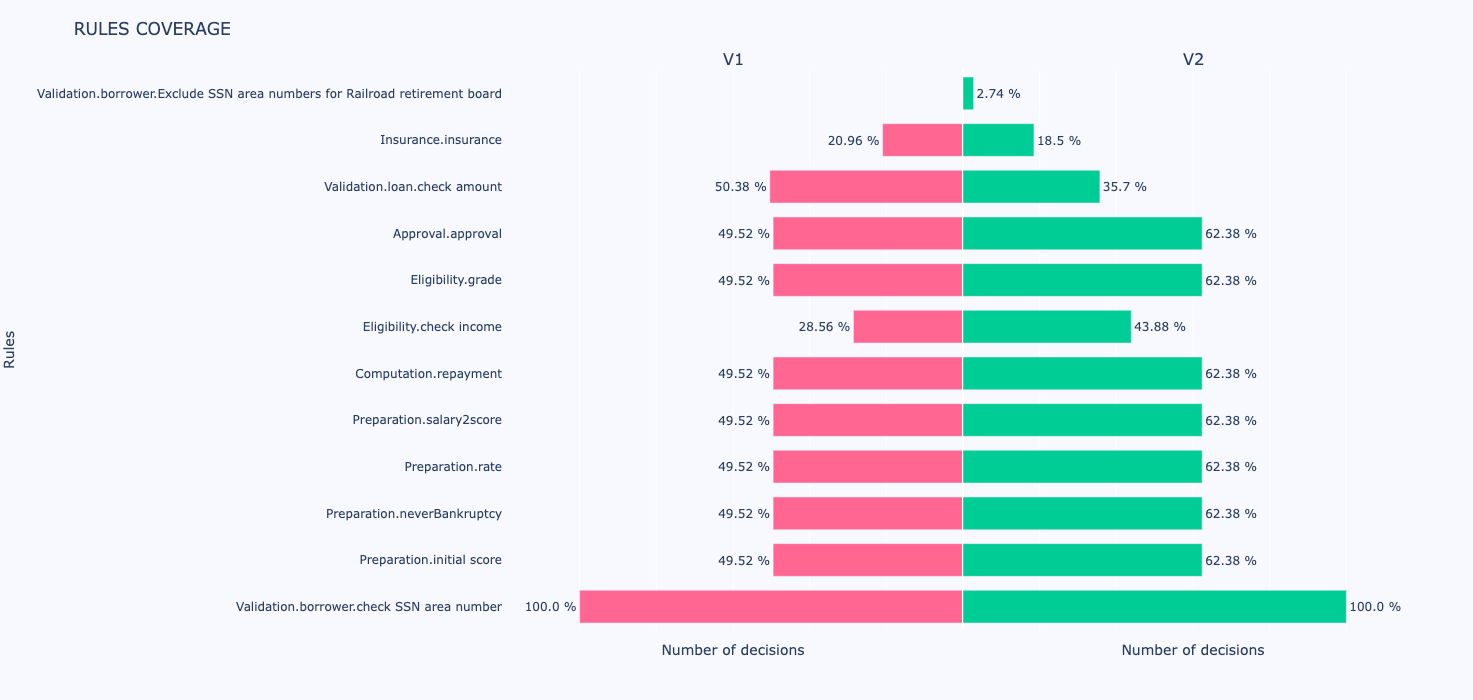

In [22]:
trace_bar_v1 = go.Bar(
            x=rules_coverage_v1["Count"],
            y=rules_coverage_v1["Rule"],
            text=[f'{item} %' for item in rules_coverage_v1['Percentage']],
            textposition="outside",
            hovertemplate="<b>%{y}</b><br><b>Count:</b> %{x}<br><b>Percentage:</b> %{text}<extra></extra>",
            orientation='h',
            width=0.7, 
            showlegend=False, 
            marker_color=px.colors.qualitative.Plotly[6])

trace_bar_v2 = go.Bar(
            x=rules_coverage_v2["Count"],
            y=rules_coverage_v2["Rule"],
            text=[f'{item} %' for item in rules_coverage_v2['Percentage']],
            textposition="outside",
            hovertemplate="<b>%{y}</b><br><b>Count:</b> %{x}<br><b>Percentage:</b> %{text}<extra></extra>",
            orientation='h',
            width=0.7, 
            showlegend=False, 
            marker_color=px.colors.qualitative.Plotly[2])

fig = make_subplots(rows=1, cols=2,
                    specs=[[{}, {}]],
                    shared_xaxes=False,
                    shared_yaxes=True, horizontal_spacing=0,
                    subplot_titles=("V1", "V2")
                    )

fig.append_trace(trace_bar_v1, row=1, col=1)
fig.append_trace(trace_bar_v2, row=1, col=2)

fig.update_xaxes(showticklabels=False, title_text="Number of decisions", row=1, col=1, range=[datasink_v1.shape[0]*1.2, 0])
fig.update_xaxes(showticklabels=False, title_text="Number of decisions", row=1, col=2, range=[0, datasink_v2.shape[0]*1.2])
fig.update_yaxes(title_text="Rules", row=1, col=1)

fig.update_layout(
    title='RULES COVERAGE',
    legend=dict(x=0.029, y=1.038, font_size=10),
    margin=dict(l=100, r=50, t=70, b=70),
    height=700,
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
)

fig.show()

### 6.2 Rule coverage comparison

This view show the differences in the rule coverages. 100% means that the rule has been executed in all decisions. This view pinpoints the rule execution differences between v1 and v2 decision services.

In [23]:
rule_percentage_v1 = dict(zip(rules_coverage_v1["Rule"], rules_coverage_v1["Percentage"]))
rule_percentage_v2 = dict(zip(rules_coverage_v2["Rule"], rules_coverage_v2["Percentage"]))

rule_names = set(list(rule_percentage_v1.keys())+list(rule_percentage_v2.keys()))
rules_coverage_diff = dict()

for rule_name in rule_names:
    if rule_name in rules_coverage_v1["Rule"].values and rule_name in rules_coverage_v2["Rule"].values:
        rules_coverage_diff[rule_name] = rule_percentage_v2[rule_name] - rule_percentage_v1[rule_name]
    
    if rule_name not in rules_coverage_v1["Rule"].values and rule_name in rules_coverage_v2["Rule"].values:
        rules_coverage_diff[rule_name] = rule_percentage_v2[rule_name] - 0
    
    if rule_name in rules_coverage_v1["Rule"].values and rule_name not in rules_coverage_v2["Rule"].values:
        rules_coverage_diff[rule_name] = 0 - rule_percentage_v1[rule_name]

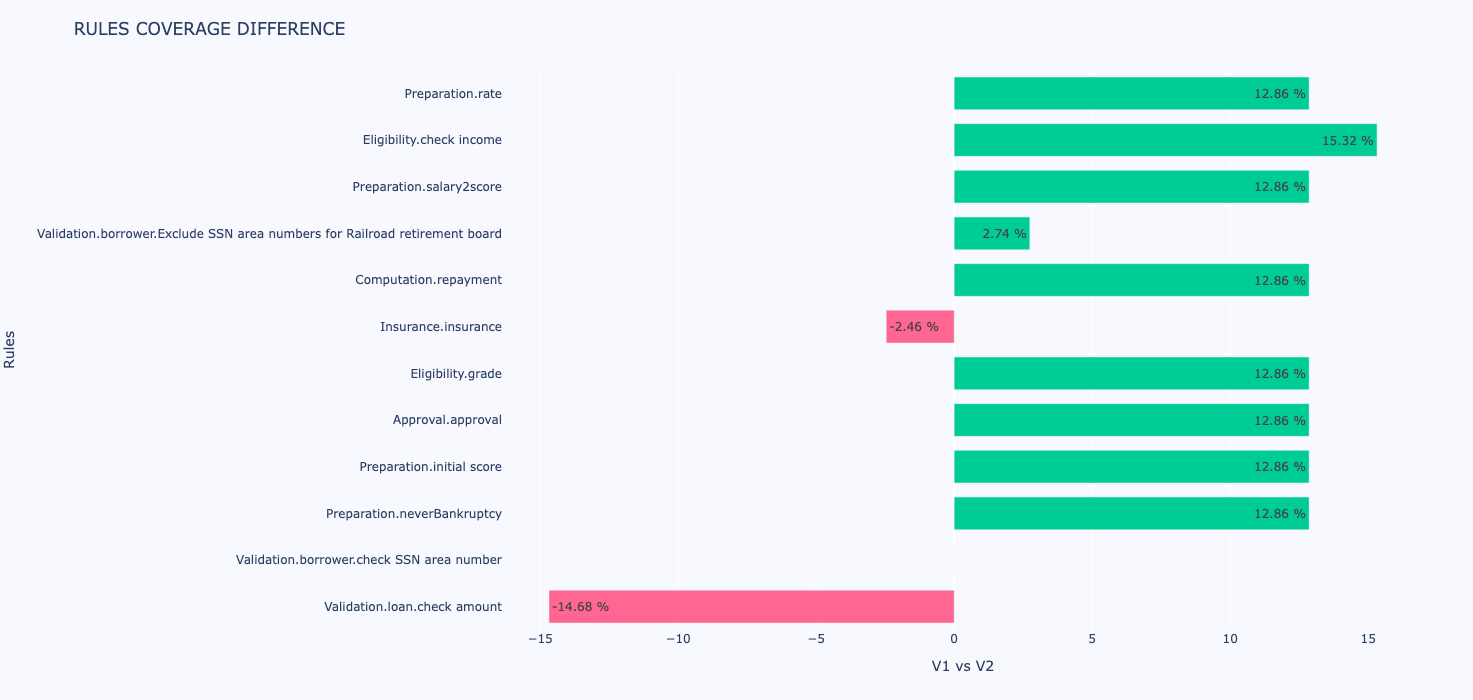

In [24]:
fig = go.Figure(go.Bar(
            x=list(rules_coverage_diff.values()),
            y=list(rules_coverage_diff.keys()),
            text=['{:.2f} %'.format(item) for item in list(rules_coverage_diff.values())], 
            marker_color=[px.colors.qualitative.Plotly[6] if item<=0 else px.colors.qualitative.Plotly[2] for item in list(rules_coverage_diff.values())],
            textposition="inside",
            hovertemplate="<b>%{y}</b><br><b>Count:</b> %{x}<br><b>Percentage:</b> %{text}<extra></extra>",
            width=0.7, 
            showlegend=False,
            orientation='h'))

fig.update_xaxes(title_text='V1 vs V2')
fig.update_yaxes(title_text='Rules')

fig.update_layout(
    title='RULES COVERAGE DIFFERENCE',
    legend=dict(x=0.029, y=1.038, font_size=10),
    margin=dict(l=100, r=50, t=70, b=70),
    height=700,
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
)

fig.show()

## Conclusion

This notebook shows a business report to compare a champion and a challenger versions of a decision automation. It leverages automated decisions performed by IBM Cloud Pak for Business Automation and more precisely Automation Decision services. This report has been generated by the SimuLatte project that takes care of the simulation and the run of report templates.

Tiémoko Dembélé and Pierre Feillet are members of IBM France lab and developping actively the SimuLatte project to empower simulations for business automation.